In [33]:
# Imports
import os
from dotenv import load_dotenv
import torch
from torch import nn
from sklearn.model_selection import StratifiedKFold
from torchvision import datasets, models
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import copy

print(torch.__version__)

2.9.1+cu126


### Data Augmentation

In [25]:
# Separate transfrom settings
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Convert to greyscale
    transforms.Resize((256, 256)),  # resize all images standarization
    transforms.RandomHorizontalFlip(), # Flipping data
    transforms.ToTensor(),          # convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize grayscale images
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # No flipping for validation
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [52]:
# Separate transfrom settings for ResNet
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # resize all images standarization
    transforms.RandomHorizontalFlip(), # Flipping data
    transforms.ToTensor(),          # convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize grayscale images
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # No flipping for validation
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

### Retrieving our data

In [53]:
load_dotenv()
train_dir = os.getenv('ORG_TRAIN_DIR')
test_dir  = os.getenv('ORG_TEST_DIR')

# Loading in datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
validate_data = datasets.ImageFolder(root=train_dir, transform=val_transform)
test_data  = datasets.ImageFolder(root=test_dir, transform=val_transform)

In [51]:
test_data

Dataset ImageFolder
    Number of datapoints: 624
    Root location: /home/loosh/python/ic/kaggle_data/organised_data/TEST
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

### Checking data size

In [60]:
print(train_data.class_to_idx)

print()

# Training data
train_label_counts = Counter(train_data.targets)
print("Training Data is:")
print(f"Normal   : {train_label_counts[0]}")
print(f"Pnemonia : {train_label_counts[1]}")

print()

# Validate data
validate_label_counts = Counter(validate_data.targets)
print("Validate Data is:")
print(f"Normal   : {validate_label_counts[0]}")
print(f"Pnemonia : {validate_label_counts[1]}")


print()

# Testing data
test_label_counts = Counter(test_data.targets)
print("Testing Data is:")
print(f"Normal   : {test_label_counts[0]}")
print(f"Pnemonia : {test_label_counts[1]}")

{'Normal': 0, 'Pnemonia': 1}

Training Data is:
Normal   : 1342
Pnemonia : 3944

Validate Data is:
Normal   : 1342
Pnemonia : 3944

Testing Data is:
Normal   : 234
Pnemonia : 390


### Handling Imbalanced Dataset and Setting Up DataLoader

via Weighted Sampler

In [54]:
batch_size = 16

# For Training Data
# Weighted sampler
train_targets = train_data.targets
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype= torch.float32)

# Assigning weights to all labels (Weights Generation)
sample_weights = class_weights[train_targets]

train_sampler = WeightedRandomSampler(
    weights= sample_weights,
    num_samples= len(sample_weights),
    replacement=True
)

# Creating Training and Testing dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

### Visualizing a single batch

Image Batch: torch.Size([16, 1, 256, 256])
Labels Batch: tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])


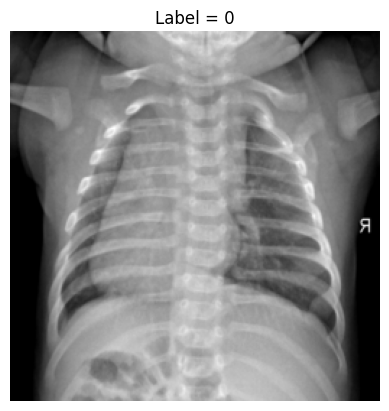

In [51]:
images, labels = next(iter(train_loader))

print(f"Image Batch: {images.shape}")
print(f"Labels Batch: {labels}")

img = images[3].permute(1,2,0).squeeze()
plt.imshow(img, cmap='gray')
plt.title(f"Label = {labels[3].item()}")
plt.axis('off')
plt.show()

### Creating model

In [122]:
# Creating model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# CNN
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 256x256x1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        # After 5 pools: 256 -> 128 -> 64 -> 32 -> 16 -> 8
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 128x128
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 64x64
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 32x32
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 16x16
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # 8x8
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    
# Initializing model
model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_featur

### Creating Early Stopping Class

retrieved from Jeff Heaton

https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_04_1_kfold.ipynb

In [37]:
# Early stopping (see module 3.4)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience # How many epochs to wait before stopping
        self.min_delta = min_delta # Change in loss to be counted as improvement
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):

        # Assign current best loss
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict()) # and saving best model

        # Update and saving lastest model weights if better is found 
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        
        # Continue normally until it reaches epoch 5
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights: # If there's a saved weight, reload it back in
                    model.load_state_dict(self.best_model)
                return True
        return False


### Training Data

In [38]:
# Training Data
def train(dataloader, model, loss_fn, optimizer):
    train_loss_list = []
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader, 0):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Computing prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        
    avg_train_loss = total_loss / len(dataloader)
    train_loss_list.append(avg_train_loss)
    return train_loss_list

### Testing Data

In [39]:
def test(dataloader, model, loss_fn):

    validation_loss = []
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Perform prediction
            pred = model(X)
            loss = loss_fn(pred, y)
            _, predicted = torch.max(pred, 1)

            # Computing statistics
            total += y.size(0)
            correct += (predicted == y).sum().item()
            total_loss += loss.item()

    # Computing statistics
    avg_loss = total_loss/len(dataloader)
    validation_loss.append(avg_loss)
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

    return accuracy, avg_loss

In [40]:
# Function for Cross Validation training (with validation)

def run_sequence(train_DL, test_DL, model, loss_fn, optimizer, epochs):

    # Statistics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    early_stopping = EarlyStopping(patience=5)

    for epoch in range(epochs):

        print(f"Epoch Number {epoch + 1}")
        train_loss = train(train_DL, model, loss_fn, optimizer)
        accuracy, val_loss = test(test_DL, model, loss_fn)

        # Storing statistics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)

        # Early stopping
        stop = early_stopping(model, val_loss)
        print(early_stopping.status)
        if stop:
            print("Early stopping triggered!")
            break

    return history

### Utilizing ResNet models

via Transfer Learning, so we freeze all layers besides the final layer (aka makes it non-trainable)


In [41]:
class ResNetClassifier:
    def __init__(self, num_classes=2, device='cuda', freeze_backbone=True):
        self.device = device
        self.model = models.resnet18(pretrained=True)

        # Replace final layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

        self.model = self.model.to(self.device)

        if freeze_backbone:
            self.freeze_backbone()
        else:
            self.unfreeze_backbone()

    def freeze_backbone(self):
        """Freeze all layers except final layer."""
        for name, param in self.model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def unfreeze_backbone(self):
        """Unfreeze all layers of the model."""
        for param in self.model.parameters():
            param.requires_grad = True

    def get_model(self):
        """Return the model object for training."""
        return self.model


### Standard Epoch cycle

In [67]:
epochs = 10

for epoch in range(epochs):

    print(f"Epoch {epoch + 1}")
    train(train_loader, model=model, loss_fn=loss_function, optimizer=optimizer)
    test(test_loader, model = model, loss_fn=loss_function)
    print("-" * 20)

Epoch 1
loss: 0.661714 [   16/ 5286]
loss: 0.111108 [ 1616/ 5286]
loss: 0.093550 [ 3216/ 5286]
loss: 0.033570 [ 4816/ 5286]
Test Accuracy: 78.85%, Loss: 0.6131
--------------------
Epoch 2
loss: 0.314414 [   16/ 5286]
loss: 0.007737 [ 1616/ 5286]
loss: 0.176407 [ 3216/ 5286]
loss: 0.061041 [ 4816/ 5286]
Test Accuracy: 69.55%, Loss: 1.5938
--------------------
Epoch 3
loss: 0.323562 [   16/ 5286]
loss: 0.008998 [ 1616/ 5286]
loss: 0.012506 [ 3216/ 5286]
loss: 0.072111 [ 4816/ 5286]
Test Accuracy: 80.45%, Loss: 0.8785
--------------------
Epoch 4
loss: 0.015280 [   16/ 5286]
loss: 0.358987 [ 1616/ 5286]
loss: 0.010660 [ 3216/ 5286]
loss: 0.002283 [ 4816/ 5286]
Test Accuracy: 76.76%, Loss: 1.1296
--------------------
Epoch 5
loss: 0.082304 [   16/ 5286]
loss: 0.027565 [ 1616/ 5286]
loss: 0.094111 [ 3216/ 5286]
loss: 0.022611 [ 4816/ 5286]
Test Accuracy: 80.77%, Loss: 0.8306
--------------------
Epoch 6
loss: 0.009658 [   16/ 5286]
loss: 0.014575 [ 1616/ 5286]
loss: 0.079342 [ 3216/ 5286]


### Cross Validation Epoch Loop for Training and Validation

In [ ]:
torch.manual_seed(40)

# KFold for imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
# Early stopping params
batch_size = 16
epochs = 10
history_lst = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_targets)), train_targets)):

    # Creating data ========================================

    # Subset Data from current SKFold
    train_subset = Subset(train_data, train_idx)
    val_subset = Subset(train_data, val_idx)

    # Training Data modification via Weighted sampler
    train_targets = np.array(train_data.targets) 
    train_targets = train_targets[train_idx] # Retrieve data only in the SKFold
    class_counts = np.bincount(train_targets)
    class_weights = 1. / torch.tensor(class_counts, dtype= torch.float32)

    # Assigning weights to all labels (Weights Generation)
    sample_weights = class_weights[train_targets]

    train_sampler = WeightedRandomSampler(
        weights= sample_weights,
        num_samples= len(sample_weights),
        replacement=True
        )
    
    # Dataloader for both training and validating data
    train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

    # Reinitializing model and optimizers =================================
    model = NeuralNetwork().to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr= 0.001, momentum=0.9)

    print(f"Fold {fold + 1}")

    history = run_sequence(train_loader, val_loader, model, loss_function, optimizer, epochs)
    history_lst.append(history)




Fold 1
Epoch Number 1
loss: 0.762058 [   16/ 4228]
loss: 0.445459 [ 1616/ 4228]
loss: 0.144763 [ 3216/ 4228]
Test Accuracy: 94.80%, Loss: 0.1373

Epoch Number 2
loss: 0.186202 [   16/ 4228]
loss: 0.028385 [ 1616/ 4228]
loss: 0.009293 [ 3216/ 4228]
Test Accuracy: 96.60%, Loss: 0.0940
Improvement found, counter reset to 0
Epoch Number 3
loss: 0.013214 [   16/ 4228]
loss: 0.032740 [ 1616/ 4228]
loss: 0.046320 [ 3216/ 4228]
Test Accuracy: 95.37%, Loss: 0.1195
No improvement in the last 1 epochs
Epoch Number 4
loss: 0.009082 [   16/ 4228]
loss: 0.014982 [ 1616/ 4228]
loss: 0.042483 [ 3216/ 4228]
Test Accuracy: 97.26%, Loss: 0.0749
Improvement found, counter reset to 0
Epoch Number 5
loss: 0.003994 [   16/ 4228]
loss: 0.108975 [ 1616/ 4228]
loss: 0.122051 [ 3216/ 4228]
Test Accuracy: 96.98%, Loss: 0.0715
Improvement found, counter reset to 0
Epoch Number 6
loss: 0.001381 [   16/ 4228]
loss: 0.001609 [ 1616/ 4228]
loss: 0.028371 [ 3216/ 4228]
Test Accuracy: 97.45%, Loss: 0.0687
Improvement fo

### Cross Validation Epoch Loop for Training and Validation (with Transfer Learning)

In [ ]:
torch.manual_seed(40)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# KFold for imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
# Early stopping params
batch_size = 16
epochs = 10
freezed_history_lst = []
unfreezed_history_lst = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_data.targets)), train_data.targets)):

    # Creating data ========================================

    # Subset Data from current SKFold
    train_subset = Subset(train_data, train_idx)
    val_subset = Subset(train_data, val_idx)

    # Training Data modification via Weighted sampler
    train_targets = np.array(train_data.targets) 
    train_targets = train_targets[train_idx] # Retrieve data only in the SKFold
    class_counts = np.bincount(train_targets)
    class_weights = 1. / torch.tensor(class_counts, dtype= torch.float32)

    # Assigning weights to all labels (Weights Generation)
    sample_weights = class_weights[train_targets]

    train_sampler = WeightedRandomSampler(
        weights= sample_weights,
        num_samples= len(sample_weights),
        replacement=True
        )
    
    # Dataloader for both training and validating data
    train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

    # Reinitializing model and optimizers =================================
    resnet = ResNetClassifier(freeze_backbone=True)
    optimizer = torch.optim.Adam(resnet.get_model().fc.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    # Freezing model
    print("Classifier Training (Final Layer only)")
    resnet.freeze_backbone()
    freezed_model_hist = run_sequence(train_loader, val_loader, resnet.get_model(), loss_fn, optimizer, epochs)

    # Unfreeze model
    resnet.unfreeze_backbone()
    optimizer = torch.optim.Adam(resnet.get_model().parameters(), lr=1e-4) # lesser learning rate for fine tuning

    print("Fine tuning entire network, Unfreezing model")
    resnet.unfreeze_backbone()
    unfreezed_model_hist = run_sequence(train_loader, val_loader, resnet.get_model(), loss_fn, optimizer, epochs)

    freezed_history_lst.append(freezed_model_hist)
    unfreezed_history_lst.append(unfreezed_model_hist)

Using cuda device


/home/loosh/python/ic/ic_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/loosh/python/ic/ic_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classifier Training (Final Layer only)
Epoch Number 1
loss: 0.646645 [   16/ 4228]
loss: 0.393604 [ 1616/ 4228]
loss: 0.125112 [ 3216/ 4228]
Test Accuracy: 93.95%, Loss: 0.1726

Epoch Number 2
loss: 0.167295 [   16/ 4228]
loss: 0.158347 [ 1616/ 4228]
loss: 0.112200 [ 3216/ 4228]
Test Accuracy: 95.27%, Loss: 0.1370
Improvement found, counter reset to 0
Epoch Number 3
loss: 0.263624 [   16/ 4228]
loss: 0.245889 [ 1616/ 4228]
loss: 0.024355 [ 3216/ 4228]
Test Accuracy: 95.18%, Loss: 0.1388
No improvement in the last 1 epochs
Epoch Number 4
loss: 0.200274 [   16/ 4228]
loss: 0.345336 [ 1616/ 4228]
loss: 0.155297 [ 3216/ 4228]
Test Accuracy: 96.12%, Loss: 0.1136
Improvement found, counter reset to 0
Epoch Number 5
loss: 0.416341 [   16/ 4228]
loss: 0.047936 [ 1616/ 4228]
loss: 0.185917 [ 3216/ 4228]
Test Accuracy: 95.46%, Loss: 0.1217
No improvement in the last 1 epochs
Epoch Number 6
loss: 0.338922 [   16/ 4228]
loss: 0.226059 [ 1616/ 4228]
loss: 0.046753 [ 3216/ 4228]
Test Accuracy: 95.18

In [43]:
for fold, history in enumerate(freezed_history_lst):
    print(f"\n--- Fold {fold+1} Summary ---")
    print(f"Best Val Accuracy: {max(history['val_accuracy']):.2f}%")
    print(f"Final Train Loss: {history['train_loss'][-1]}")
    print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")


--- Fold 1 Summary ---
Best Val Accuracy: 96.41%
Final Train Loss: [0.14231339765115167]
Final Val Loss: 0.1029

--- Fold 2 Summary ---
Best Val Accuracy: 96.22%
Final Train Loss: [0.134693599397422]
Final Val Loss: 0.1601


In [56]:
for fold, history in enumerate(unfreezed_history_lst):
    print(f"\n--- Fold {fold+1} Summary ---")
    print(f"Best Val Accuracy: {max(history['val_accuracy']):.2f}%")
    print(f"Final Train Loss: {history['train_loss'][-1]}")
    print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")


--- Fold 1 Summary ---
Best Val Accuracy: 98.87%
Final Train Loss: [0.02395665462317993]
Final Val Loss: 0.0344

--- Fold 2 Summary ---
Best Val Accuracy: 98.96%
Final Train Loss: [0.019028057797764494]
Final Val Loss: 0.0482


In [82]:
def plot_all_folds(epochs, history_list):
    print("Generating Loss Graph...")

    plt.figure(figsize=(8,5))
    plot_epoch = list(range(1, epochs + 1))

    for i, fold in enumerate(history_list):
        train_loss = flatten_loss(fold["train_loss"])
        plt.plot(plot_epoch, train_loss, label=f"Fold {i+1}")

    plt.title("Training Loss Across All Folds")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(plot_epoch)
    plt.legend()
    plt.grid(True)
    plt.savefig("validation_all_folds.png")
    print("Graph Generation Completed")

def flatten_loss(loss_list):
    # If elements are lists, flatten them
    if isinstance(loss_list[0], list) or isinstance(loss_list[0], tuple):
        return [x[0] for x in loss_list]
    return loss_list


Generating Loss Graph...
Graph Generation Completed


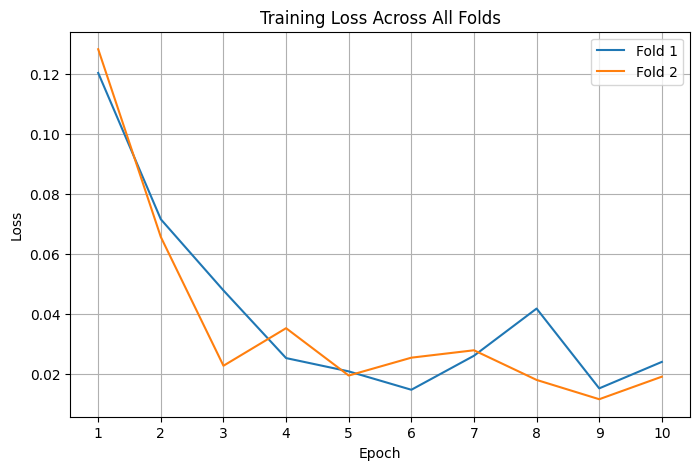

In [83]:
plot_all_folds(epochs, unfreezed_history_lst)

### Generating graph

Generating Loss Graph...
Graph Generation Completed


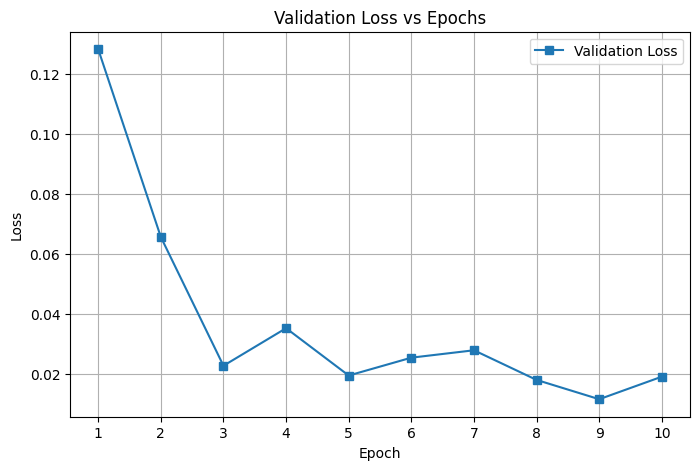

In [61]:
print("Generating Loss Graph...")
plot_epoch = list(range(1, epochs + 1))

plt.figure(figsize=(8,5))
plt.plot(plot_epoch, history['train_loss'], marker='s', label='Validation Loss')

plt.title("Validation Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(plot_epoch)
plt.legend()
plt.grid(True)
plt.savefig("validation_plot.png")
print("Graph Generation Completed")

### Testing on Unseen Data

In [55]:
test(test_loader, resnet.get_model(), loss_fn)

Test Accuracy: 87.66%, Loss: 0.6428


(87.66025641025641, 0.6427943478662107)